# CNN Outline
Author: Ding Shuya
1. Motivation
2. Data Loading 
3. Data Preprocessing 

>1. Data Analysis 
>2. Data Preprocessing
>3. Data Normalization
>4. Categorical

4. Model Structures
>1. Hyperparameter Tuning
5. Training 
6. Performance Improvment
7. Evaluation 


## 1. Motivation

Convolutional neural network(CNN) is well-known deep learning technique to solve image classification problems. 

Hence, we will try to solve quick draw tasks using CNN. 

## 2. Data Loading

Our group will use 5 classes: 'calendar', 'snowman', 'penguin', 'blackberry', 'teddy-bear'. 

Each class have exactly 128153 data. Basic datasets are already processed by **Liu Chang**. 

In [4]:
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [6]:
import os
import pickle

def _cut_stroke(x,ratio=1):
    if ratio==1:
        return x
    return [i[:int(len(i)*ratio)] for i in x]
def get_dataset(dataset_path='',dataset_name='1102_05b633244.dms',train_r=1.0,test_r=1.0):
    (train_Recognized, train_X, train_Y, test_Recognized, test_X, test_Y)=pickle.load(open(os.path.join(dataset_path,dataset_name),'rb'))
    train_X=_cut_stroke(train_X,train_r)
    test_X=_cut_stroke(test_X,test_r)
    return train_Recognized,train_X,train_Y,test_Recognized,test_X,test_Y

In [7]:
dataset_path='/home/di0002ya/quickdraw/dsy'

In [5]:
train_Recognized,train_X,train_Y,test_Recognized,test_X,test_Y=get_dataset(dataset_path = dataset_path, dataset_name = '1102_05b633244.dms',train_r=1.0,test_r=1.0)

## 3. Data Preprocessing

### 3.1 Data Analysis

In [5]:
print('training image datasets has', len(train_X))
print('testing image datasets has', len(test_X))

training image datasets has 506595
testing image datasets has 126649


Basic datasets are made up of multiple strokes. 

Each strokes are represented by X (dimension 0) and Y (dimension 1) lists. 

Lenght of X or Y reprensents the length of each stroke. 

In [6]:
print('Let us using 1st train sample as example to investigate the structure of data')
print('Number of strokes of 1st sketch is', len(train_X[0]))
print('1st strokes has', len(train_X[0][0][0]), 'points')

Let us using 1st train sample as example to investigate the structure of data
Number of strokes of 1st sketch is 3
1st strokes has 47 points


### 3.2 Data Preprocessing

Normally, RGB images will have 3 channels. Videa will have 4 channels.

In our case, we only deal with grey scale sketch which means that channel will be 1 in our case. 

In order to preprocess sequence stroke data to image data, we will draw each skeches on 42\*42\*1 arrays. The value of each existing points is 1. 

In [7]:
import pandas as pd
df_trainX = pd.DataFrame({'drawing':train_X})
df_testX = pd.DataFrame({'drawing':test_X})

In [8]:
# Calculate Stroke Number of Each Image
df_trainX['stroke_number'] = df_trainX['drawing'].str.len()
df_testX['stroke_number'] = df_testX['drawing'].str.len()

We should do normalization in order to make training less sensitive to the scale of the features. Moreover, it will make optimization well-conditioned, improving the convergence rate of gradient descent. 

In [8]:
# Normalization 
def _array_normalizer(array1,Xmin,Xmax,array_min):
    '''
    function:
        - normalize X,Y array by range of X
        - used in feature_eng_pt2
    input:
        array1 = array that you want to normalize (1D array or list)
        Xmin = minimum value of your X array (int)
        Xmax = maximum value of your X array (int)
        array_min = minimum value of array1

    output:
        normalized array of array1
    '''
    return (np.array(array1)-np.array([array_min]*len(array1)))/float(Xmax-Xmin)

In [9]:
import numpy as np
def preprocess(df):
    X = {} # Dimension 0: storing existing points for each images
    Y = {} # Dimension 1: storing existing points for each images
    Ymax = {} # Dimension 1: storing Ymax for each images
    image_pile = np.zeros((df.shape[0],42*42*1)) # Image Array storing final image info
    orig_index = df.index
    for i in range(df.shape[0]):
        num = df.loc[i,'stroke_number']
        #store X,Y of the stroke in a temp list
        Xt = [df.loc[i,'drawing'][stroke][0] for stroke in range(num)]
        Yt = [df.loc[i,'drawing'][stroke][1] for stroke in range(num)]
        #Flatten Xt & Yt
        Xtemp = [item for stroke in Xt for item in stroke]
        Ytemp = [item for stroke in Yt for item in stroke]
        # Normalize Xtemp&Ytemp for ith drawing
        Xmintemp = np.min(Xtemp)-10
        Xmaxtemp = np.max(Xtemp)+10
        Ymintemp = np.min(Ytemp)-10
        Xnorm = _array_normalizer(Xtemp, Xmintemp,Xmaxtemp,Xmintemp)
        Ynorm = _array_normalizer(Ytemp, Xmintemp,Xmaxtemp,Ymintemp)
        Ymax[i] = np.max(Ynorm)
        X[i] = Xnorm
        Y[i] = Ynorm
        # Draw existing points on the image with corresponding positions
        image = np.zeros((42,42))
        xarray = np.around(np.array(Xnorm)*42)
        yarray = np.around(np.array(Ynorm)*42/float(Ymax[i]))
        xarray[xarray>=42.] = 41
        yarray[yarray>=42.] = 41

        for item in range(len(xarray)):
            image[int(np.around(yarray[item])),int(np.around(xarray[item]))] = 1
        image_pile[i] = image.reshape(1,42*42*1)

    # create new features
    df['Ymax'] = pd.Series(Ymax)
    df['X'] = pd.Series(X)
    df['Y'] = pd.Series(Y)

    #return pd.DataFrame(image_pile, index = orig_index)
    df_final = pd.DataFrame(image_pile, index = orig_index)
    return df_final

In [11]:
trainX = preprocess(df_trainX)

In [12]:
#Convert to Array & Normalization 
trainX_ar = np.array(trainX)

In [13]:
trainY_ar = np.array(train_Y)

In [14]:
# Normalization X values 
data_np = np.array(trainX_ar)
data_key = data_np[:,-1]
trainX = data_np[:,0:42*42]
trainX /= 10000 
trainX += 1 
trainX[trainX == 1.0] = 0

In [15]:
trainX = trainX.reshape(len(trainX),42,42,1)

In [16]:
from keras.utils import np_utils
trainY_label = np_utils.to_categorical(trainY_ar,5)

Using TensorFlow backend.


In [17]:
#Save Data
np.save('/home/di0002ya/quickdraw/dsy/trainX.npy', trainX)
np.save('/home/di0002ya/quickdraw/dsy/trainY_label.npy', trainY_label)

In [6]:
import numpy as np
trainX = np.load('/home/di0002ya/quickdraw/dsy/trainX.npy')
trainY = np.load('/home/di0002ya/quickdraw/dsy/trainY_label.npy')

## 4. Model Structures

### 4.1 Hyperparameter Tuning

We firstly build a simple CNN model. Moreover, dropout layer, maxpooling layer will also be used. Order of these layers will be based on the following rules. 
1. Dropout 
2. Linear/Dense/Conv
3. Batch Normalization
4. Activations
5. Maxpooling

'Relu' will be used after convolutional layer and dense layer. 

Output activation function will be 'softmax' as this is a classification problems. 

Adam is the selected optimizer as Adam is the best optimizer currently. 

Loss function will be 'cross-entropy'. 

Following parameters will be tuned:
1. Kernel Size
2. Dropout Rate
3. Batch Size
4. Number of Filters
5. Dense Neurons

In [7]:
import pandas as pd
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.models import load_model
import tensorflow as tf

Using TensorFlow backend.


#### 4.1.1 Kernel Size

In [8]:
#Declare 
args = {}
args['poolS'] = 2 #Pooling Size
args['dropout'] = 0.2 # Dropout Rate
args['batch'] = 512 #Batch Size
args['epochs']=1 # Epochs
args['len_category']=5 # Number of Class
args['num_filters']=64 # Number of Filters
args['dense_neuron']=100 # Dense Neurons

ls = [3,5,7] #Kernel size

In [9]:
def tune_para(name,ls,args,trainX,trainY_label):
    # Model Building
    print(name,' will be tuned')
    for i in range(len(ls)):
        args[name] = ls[i]
        print('value is ', ls[i])
        model = Sequential()
        model.add(Convolution2D(args['num_filters'],args['kernelS'],args['kernelS'], activation='relu', input_shape=(42,42,1)))
        model.add(MaxPooling2D(pool_size=(args['poolS'],args['poolS'])))
        model.add(Flatten())
        model.add(Dropout(args['dropout']))
        model.add(Dense(args['dense_neuron'], activation='relu'))
        model.add(Dropout(args['dropout'] ))
        model.add(Dense(args['len_category'], activation='softmax'))

        model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
        model.fit(trainX, trainY_label,
                  batch_size = args['batch'], nb_epoch= args['epochs'], 
                  verbose=2,validation_split=0.2)
    

In [15]:
tune_para(name='kernelS',ls=ls,args=args,trainX=trainX,trainY_label=trainY)

kernelS  will be tuned
value is  3


/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", input_shape=(42, 42, 1...)`
  
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 405276 samples, validate on 101319 samples
Epoch 1/1
405276/405276 [==============================] - 31s 76us/step - loss: 0.4739 - acc: 0.8388 - val_loss: 0.3512 - val_acc: 0.8816
value is  5


/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation="relu", input_shape=(42, 42, 1...)`
  


Train on 405276 samples, validate on 101319 samples
Epoch 1/1
405276/405276 [==============================] - 24s 58us/step - loss: 0.4602 - acc: 0.8432 - val_loss: 0.3180 - val_acc: 0.8935
value is  7


/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), activation="relu", input_shape=(42, 42, 1...)`
  


Train on 405276 samples, validate on 101319 samples
Epoch 1/1
405276/405276 [==============================] - 24s 59us/step - loss: 0.4550 - acc: 0.8453 - val_loss: 0.3004 - val_acc: 0.8991


Kernel Size will be **7**

#### 4.1.2 Dropout Rate

In [16]:
args['kernelS'] = 7
ls = [0.2,0.4,0.6]
tune_para(name='dropout',ls=ls,args=args,trainX=trainX,trainY_label=trainY)

dropout  will be tuned
value is  0.2


/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), activation="relu", input_shape=(42, 42, 1...)`
  
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 405276 samples, validate on 101319 samples
Epoch 1/1
405276/405276 [==============================] - 26s 64us/step - loss: 0.4594 - acc: 0.8437 - val_loss: 0.3078 - val_acc: 0.8963
value is  0.4
Train on 405276 samples, validate on 101319 samples
Epoch 1/1
405276/405276 [==============================] - 27s 65us/step - loss: 0.5178 - acc: 0.8241 - val_loss: 0.3413 - val_acc: 0.8862
value is  0.6
Train on 405276 samples, validate on 101319 samples
Epoch 1/1
405276/405276 [==============================] - 27s 66us/step - loss: 0.6087 - acc: 0.7941 - val_loss: 0.3835 - val_acc: 0.8712


Dropout rate will be **0.2**

#### 4.1.3 Batch Size

In [10]:
args['dropout'] = 0.2
args['kernelS'] = 7
ls = [32,64,128,512]
tune_para(name='batch',ls=ls,args=args,trainX=trainX,trainY_label=trainY)

batch  will be tuned
value is  32


/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), activation="relu", input_shape=(42, 42, 1...)`
  
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 405276 samples, validate on 101319 samples
Epoch 1/1
 - 121s - loss: 0.3840 - acc: 0.8702 - val_loss: 0.2872 - val_acc: 0.9038
value is  64
Train on 405276 samples, validate on 101319 samples
Epoch 1/1
 - 64s - loss: 0.3904 - acc: 0.8685 - val_loss: 0.2730 - val_acc: 0.9079
value is  128
Train on 405276 samples, validate on 101319 samples
Epoch 1/1
 - 57s - loss: 0.3892 - acc: 0.8686 - val_loss: 0.2738 - val_acc: 0.9072
value is  512
Train on 405276 samples, validate on 101319 samples
Epoch 1/1
 - 47s - loss: 0.4705 - acc: 0.8404 - val_loss: 0.3113 - val_acc: 0.8947


Batch size will be **64**

#### 4.1.4 Number of filters

In [10]:
args['dropout'] = 0.2
args['kernelS'] = 7
args['batch'] = 64
ls = [30,60,100,150]
tune_para(name='num_filters',ls=ls,args=args,trainX=trainX,trainY_label=trainY)

num_filters  will be tuned
value is  30


/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (7, 7), activation="relu", input_shape=(42, 42, 1...)`
  
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 405276 samples, validate on 101319 samples
Epoch 1/1
 - 76s - loss: 0.4001 - acc: 0.8642 - val_loss: 0.2795 - val_acc: 0.9067
value is  60


/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(60, (7, 7), activation="relu", input_shape=(42, 42, 1...)`
  


Train on 405276 samples, validate on 101319 samples
Epoch 1/1
 - 77s - loss: 0.3815 - acc: 0.8717 - val_loss: 0.2716 - val_acc: 0.9087
value is  100


/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(100, (7, 7), activation="relu", input_shape=(42, 42, 1...)`
  


Train on 405276 samples, validate on 101319 samples
Epoch 1/1
 - 82s - loss: 0.3949 - acc: 0.8673 - val_loss: 0.2873 - val_acc: 0.9031
value is  150


/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(150, (7, 7), activation="relu", input_shape=(42, 42, 1...)`
  


Train on 405276 samples, validate on 101319 samples
Epoch 1/1
 - 93s - loss: 0.3710 - acc: 0.8754 - val_loss: 0.2708 - val_acc: 0.9089


Batch size will be **150**

#### 4.1.5 Dense Neurons

In [11]:
args['dropout'] = 0.2
args['kernelS'] = 7
args['batch'] = 64
args['num_filters'] = 150
ls = [30,60,100,150]
tune_para(name='dense_neuron',ls=ls,args=args,trainX=trainX,trainY_label=trainY)

dense_neuron  will be tuned
value is  30


/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(150, (7, 7), activation="relu", input_shape=(42, 42, 1...)`
  
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 405276 samples, validate on 101319 samples
Epoch 1/1
 - 85s - loss: 0.4243 - acc: 0.8573 - val_loss: 0.3080 - val_acc: 0.8960
value is  60
Train on 405276 samples, validate on 101319 samples
Epoch 1/1
 - 108s - loss: 0.4021 - acc: 0.8652 - val_loss: 0.2957 - val_acc: 0.8998
value is  100
Train on 405276 samples, validate on 101319 samples
Epoch 1/1
 - 156s - loss: 0.3674 - acc: 0.8764 - val_loss: 0.2685 - val_acc: 0.9084
value is  150
Train on 405276 samples, validate on 101319 samples
Epoch 1/1
 - 174s - loss: 0.3660 - acc: 0.8771 - val_loss: 0.2649 - val_acc: 0.9106


## 5. Training

In [25]:
#Declare 
args = {}
args['poolS'] = 2 #Pooling Size
args['dropout'] = 0.2 # Dropout Rate
args['batch'] = 128 #Batch Size
args['epochs']= 20 # Epochs
args['len_category']=5 # Number of Class
args['num_filters']=150 # Number of Filters
args['dense_neuron']=150 # Dense Neurons
args['kernelS'] = 7

In [26]:
import keras
model = Sequential()
model.add(Convolution2D(args['num_filters'],args['kernelS'],args['kernelS'], activation='relu', input_shape=(42,42,1)))
model.add(MaxPooling2D(pool_size=(args['poolS'],args['poolS'])))
model.add(Flatten())
model.add(Dropout(args['dropout']))
model.add(Dense(args['dense_neuron'], activation='relu'))
model.add(Dropout(args['dropout'] ))
model.add(Dense(args['len_category'], activation='softmax'))
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,patience=5, verbose=0, mode='auto')
model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])
model.fit(trainX, trainY, callbacks=[earlyStopping],
          batch_size = args['batch'], nb_epoch= args['epochs'], 
          verbose=2,validation_split=0.2)

/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(150, (7, 7), activation="relu", input_shape=(42, 42, 1...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


Train on 405276 samples, validate on 101319 samples
Epoch 1/20
 - 75s - loss: 0.3698 - acc: 0.8761 - val_loss: 0.2679 - val_acc: 0.9096
Epoch 2/20
 - 148s - loss: 0.2514 - acc: 0.9161 - val_loss: 0.2478 - val_acc: 0.9172
Epoch 3/20
 - 142s - loss: 0.1955 - acc: 0.9341 - val_loss: 0.2510 - val_acc: 0.9177
Epoch 4/20
 - 144s - loss: 0.1497 - acc: 0.9481 - val_loss: 0.2737 - val_acc: 0.9157
Epoch 5/20
 - 145s - loss: 0.1185 - acc: 0.9579 - val_loss: 0.2952 - val_acc: 0.9158
Epoch 6/20
 - 144s - loss: 0.0974 - acc: 0.9650 - val_loss: 0.3386 - val_acc: 0.9133
Epoch 7/20
 - 144s - loss: 0.0844 - acc: 0.9694 - val_loss: 0.3510 - val_acc: 0.9143


In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 36, 36, 150)       7500      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 18, 18, 150)       0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 48600)             0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 48600)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 150)               7290150   
_________________________________________________________________
dropout_26 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 755       
Total para

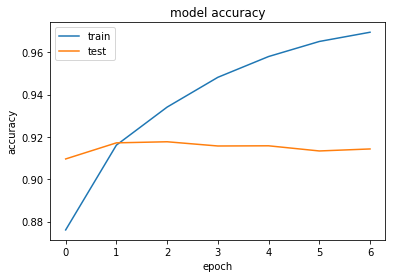

In [28]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

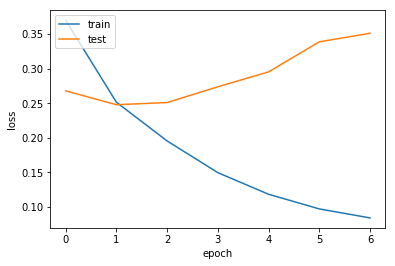

In [29]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

## 6. Performance Improvement

During training, callback of early stopping is used. Patience is set to 5 epochs. We could see that the model quickly overfitting. 

Following strategy is used:
1. Increase max pooling size
2. Increase dropout rate
3. Add one more dropout layer
4. Reduce structure dense neurons

In [31]:
#Declare 
args = {}
args['poolS'] = 3 #Pooling Size
args['dropout'] = 0.4 # Dropout Rate
args['batch'] = 128 #Batch Size
args['epochs']= 20 # Epochs
args['len_category']= 5 # Number of Class
args['num_filters']= 100 # Number of Filters
args['dense_neuron']= 50 # Dense Neurons
args['kernelS'] = 7

In [32]:
import keras
model = Sequential()
model.add(Convolution2D(args['num_filters'],args['kernelS'],args['kernelS'], activation='relu', input_shape=(42,42,1)))
model.add(MaxPooling2D(pool_size=(args['poolS'],args['poolS'])))
model.add(Flatten())
model.add(Dropout(args['dropout']))
model.add(Dense(args['dense_neuron'], activation='relu'))
model.add(Dropout(args['dropout'] ))
model.add(Dense(args['len_category'], activation='softmax'))
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,patience=5, verbose=0, mode='auto')
model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])
model.fit(trainX, trainY, callbacks=[earlyStopping],
          batch_size = args['batch'], nb_epoch= args['epochs'], 
          verbose=2,validation_split=0.2)

/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(100, (7, 7), activation="relu", input_shape=(42, 42, 1...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


Train on 405276 samples, validate on 101319 samples
Epoch 1/20
 - 51s - loss: 0.5334 - acc: 0.8200 - val_loss: 0.3289 - val_acc: 0.8881
Epoch 2/20
 - 78s - loss: 0.4032 - acc: 0.8663 - val_loss: 0.3067 - val_acc: 0.8974
Epoch 3/20
 - 82s - loss: 0.3747 - acc: 0.8757 - val_loss: 0.2841 - val_acc: 0.9038
Epoch 4/20
 - 101s - loss: 0.3585 - acc: 0.8809 - val_loss: 0.2824 - val_acc: 0.9051
Epoch 5/20
 - 89s - loss: 0.3451 - acc: 0.8847 - val_loss: 0.2743 - val_acc: 0.9078
Epoch 6/20
 - 88s - loss: 0.3363 - acc: 0.8876 - val_loss: 0.2727 - val_acc: 0.9081
Epoch 7/20
 - 101s - loss: 0.3285 - acc: 0.8894 - val_loss: 0.2731 - val_acc: 0.9083
Epoch 8/20
 - 94s - loss: 0.3233 - acc: 0.8911 - val_loss: 0.2724 - val_acc: 0.9081
Epoch 9/20
 - 101s - loss: 0.3170 - acc: 0.8934 - val_loss: 0.2672 - val_acc: 0.9101
Epoch 10/20
 - 84s - loss: 0.3138 - acc: 0.8938 - val_loss: 0.2640 - val_acc: 0.9118
Epoch 11/20
 - 101s - loss: 0.3086 - acc: 0.8951 - val_loss: 0.2632 - val_acc: 0.9119
Epoch 12/20
 - 90s

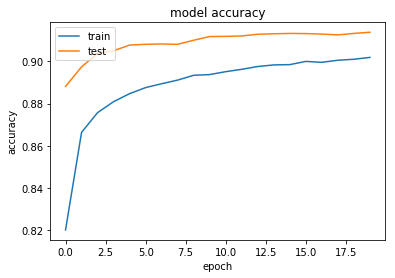

In [33]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

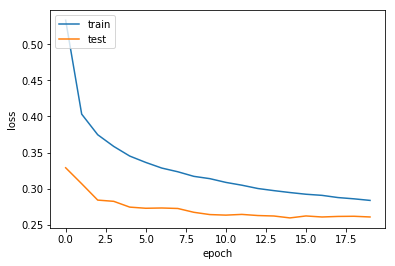

In [34]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

It is sucessfully solved overfitting issue. However, we still want to improve the performance. 

Currently, we only have 1 layer convolutional layer and epochs only 20. 

Following modifications will be done in order to increase performance:
1. Add one convolutional block
2. Increase epochs

In [35]:
args = {}
args['poolS'] = 3 #Pooling Size
args['dropout'] = 0.4 # Dropout Rate
args['batch'] = 128 #Batch Size
args['epochs']= 40 # Epochs
args['len_category']= 5 # Number of Class
args['num_filters']= 100 # Number of Filters
args['dense_neuron']= 50 # Dense Neurons
args['kernelS'] = 7

model = Sequential()
model.add(Convolution2D(args['num_filters'],args['kernelS'],args['kernelS'], activation='relu', input_shape=(42,42,1)))
model.add(MaxPooling2D(pool_size=(args['poolS'],args['poolS'])))
model.add(Dropout(args['dropout']))
model.add(Convolution2D(args['num_filters'],args['kernelS'],args['kernelS'], activation='relu', input_shape=(42,42,1)))
model.add(MaxPooling2D(pool_size=(args['poolS'],args['poolS'])))
model.add(Flatten())
model.add(Dropout(args['dropout']))
model.add(Dense(args['dense_neuron'], activation='relu'))
model.add(Dropout(args['dropout'] ))
model.add(Dense(args['len_category'], activation='softmax'))
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,patience=5, verbose=0, mode='auto')
model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])
model.fit(trainX, trainY, callbacks=[earlyStopping],
          batch_size = args['batch'], nb_epoch= args['epochs'], 
          verbose=2,validation_split=0.2)

/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(100, (7, 7), activation="relu", input_shape=(42, 42, 1...)`
  del sys.path[0]
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(100, (7, 7), activation="relu", input_shape=(42, 42, 1...)`
  app.launch_new_instance()
/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x155269714da0>>
Traceback (most recent call last):
  File "/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1448, in __del__
    def __del__(se

Train on 405276 samples, validate on 101319 samples
Epoch 1/40
 - 92s - loss: 0.5846 - acc: 0.7986 - val_loss: 0.3544 - val_acc: 0.8789
Epoch 2/40
 - 143s - loss: 0.4307 - acc: 0.8573 - val_loss: 0.3129 - val_acc: 0.8946
Epoch 3/40
 - 151s - loss: 0.4028 - acc: 0.8667 - val_loss: 0.2900 - val_acc: 0.9018
Epoch 4/40
 - 151s - loss: 0.3890 - acc: 0.8716 - val_loss: 0.2901 - val_acc: 0.9014
Epoch 5/40
 - 162s - loss: 0.3770 - acc: 0.8757 - val_loss: 0.2845 - val_acc: 0.9058
Epoch 6/40
 - 147s - loss: 0.3684 - acc: 0.8783 - val_loss: 0.2825 - val_acc: 0.9057
Epoch 7/40
 - 152s - loss: 0.3615 - acc: 0.8807 - val_loss: 0.2714 - val_acc: 0.9096
Epoch 8/40
 - 152s - loss: 0.3548 - acc: 0.8831 - val_loss: 0.2705 - val_acc: 0.9094
Epoch 9/40
 - 153s - loss: 0.3502 - acc: 0.8843 - val_loss: 0.2669 - val_acc: 0.9112
Epoch 10/40
 - 152s - loss: 0.3447 - acc: 0.8862 - val_loss: 0.2605 - val_acc: 0.9125
Epoch 11/40
 - 154s - loss: 0.3405 - acc: 0.8878 - val_loss: 0.2643 - val_acc: 0.9111
Epoch 12/40


In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 36, 36, 100)       5000      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 100)       0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 12, 12, 100)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 6, 6, 100)         490100    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 2, 2, 100)         0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 400)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 400)               0         
__________

In [37]:
model.save(dataset_path+'/cnn_full1_tune.h5')

## 7. Evaluation

In [10]:
from sklearn.metrics import accuracy_score
import pandas as pd
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn import preprocessing
from keras.utils import np_utils

In [11]:
from keras.models import load_model

In [12]:
model = load_model(dataset_path+'/cnn_full1_tune.h5')

### 7.1 test ratio = 0.5

In [173]:
_,_,_,_,test_X,test_Y=get_dataset(dataset_path = dataset_path, dataset_name = '1102_05b633244.dms',train_r=1.0,test_r=0.5)

In [174]:
import pandas as pd
df_testX = pd.DataFrame({'drawing':test_X})
df_testX['stroke_number'] = df_testX['drawing'].str.len().astype(int)

In [176]:
stroke_num = df_testX['stroke_number']
non_zero_index = np.where(np.array(stroke_num)!=0)
non_zero_index[0].shape

(122777,)

In [177]:
zero_index = np.where(np.array(stroke_num)==0)
zero_index[0].shape

(3872,)

In [178]:
test_Y_filter = np.array(test_Y)[non_zero_index[0]]

In [179]:
df_testX['stroke_number'].replace(0, np.nan, inplace=True)
df_testX.dropna(subset=['stroke_number'], inplace=True)
df_testX = df_testX.reset_index(drop=True)

In [182]:
df_testX['stroke_number'] = df_testX['stroke_number'].astype(int)

In [184]:
testX_ar = np.array(preprocess(df_testX))

In [185]:
testX_ar.shape

(122777, 1764)

In [186]:
# Normalization X values 
testX = testX_ar[:,0:42*42]
testX /= 10000 
testX += 1 
testX[testX == 1.0] = 0
testX = testX_ar.reshape(len(testX),42,42,1)
from keras.utils import np_utils
testY_label = np_utils.to_categorical(test_Y_filter,5)

In [189]:
#Save Data
np.save('/home/di0002ya/quickdraw/dsy/testX05.npy', testX)
np.save('/home/di0002ya/quickdraw/dsy/testY05_label.npy', testY_label)

In [190]:
y_predict = model.predict(testX)

In [191]:
from sklearn.metrics import accuracy_score
y_predict_label = np.argmax(y_predict,axis = 1)
y_test_label = np.argmax(testY_label,axis=1)
result = accuracy_score(y_test_label, y_predict_label)
print(result)

0.5970173566710377


### 7.2: test ratio = 0.7,0.9,1 

In [193]:
from keras.utils import np_utils
from sklearn.metrics import accuracy_score

In [196]:
def compute(ratio,model,name):
    #Load Data
    _,_,_,_,test_X,test_Y=get_dataset(dataset_path = dataset_path, dataset_name = '1102_05b633244.dms',train_r=1.0,test_r=ratio)
    df_testX = pd.DataFrame({'drawing':test_X})
    df_testX['stroke_number'] = df_testX['drawing'].str.len().astype(int)    
    stroke_num = df_testX['stroke_number']
    #Non Zero Filter Out
    non_zero_index = np.where(np.array(stroke_num)!=0)
    test_Y_filter = np.array(test_Y)[non_zero_index[0]]
    df_testX['stroke_number'].replace(0, np.nan, inplace=True)
    df_testX.dropna(subset=['stroke_number'], inplace=True)
    df_testX = df_testX.reset_index(drop=True)
    df_testX['stroke_number'] = df_testX['stroke_number'].astype(int) 
    #Reshape
    testX_ar = np.array(preprocess(df_testX))
    testX = testX_ar[:,0:42*42]
    #Normalization
    testX /= 10000 
    testX += 1 
    testX[testX == 1.0] = 0
    testX = testX_ar.reshape(len(testX),42,42,1)
    testY_label = np_utils.to_categorical(test_Y_filter,5)
    np.save('/home/di0002ya/quickdraw/dsy/testX'+name+'.npy', testX)
    np.save('/home/di0002ya/quickdraw/dsy/testY'+name+'_label.npy', testY_label)
    y_predict = model.predict(testX)
    y_predict_label = np.argmax(y_predict,axis = 1)
    y_test_label = np.argmax(testY_label,axis=1)
    result = accuracy_score(y_test_label, y_predict_label)
    print(result)

In [197]:
compute(0.7,model,'07')

0.7813515560732059


In [198]:
compute(0.9,model,'09')

0.8556651490099937


In [199]:
compute(1,model,'10')

0.9175832418732086
